In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
import time
import chess
import chess.engine
import chess.svg
import matplotlib.pyplot as plt
from collections import deque
from IPython.display import display, HTML, clear_output

import warnings
warnings.filterwarnings('ignore')

In [2]:
class ChessNN(nn.Module):
    def __init__(self):
        super(ChessNN, self).__init__()
        self.conv1 = nn.Conv2d(12, 24, kernel_size=3, padding=1)  # 12 channels for each piece type
        self.conv2 = nn.Conv2d(24, 48, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(48 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64 * 64)

    def forward(self, x):
        x = x.view(-1, 12, 8, 8)  # Reshape to match the convolutional layer input
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 48 * 8 * 8)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done, move_quality):
        # Always include move_quality as part of the stored data.
        self.buffer.append((state, action, reward, next_state, done, move_quality))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones, move_qualities = zip(*batch)
        return states, actions, rewards, next_states, dones, move_qualities

    def __len__(self):
        return len(self.buffer)


In [4]:
def board_to_tensor(board):
    board_tensor = np.zeros((12, 8, 8), dtype=np.float32)
    piece_to_idx = {'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5,
                    'P': 6, 'N': 7, 'B': 8, 'R': 9, 'Q': 10, 'K': 11}
    for i in range(64):
        piece = board.piece_at(i)
        if piece is not None:
            piece_idx = piece_to_idx.get(piece.symbol(), -1)
            if piece_idx != -1:
                row, col = divmod(i, 8)
                board_tensor[piece_idx, row, col] = 1
    return board_tensor.flatten()


In [5]:
def select_move(model, board, epsilon=0.2):
    legal_moves = list(board.legal_moves)
    if not legal_moves:
        return None, 0

    if random.random() < epsilon:  # Exploration
        move = random.choice(legal_moves)
        return move, 0  # Score for random moves is 0
    else:  # Exploitation
        board_tensor = torch.FloatTensor([board_to_tensor(board)])
        with torch.no_grad():
            predictions = model(board_tensor).view(64, 64)
        move_scores = {move: predictions[move.from_square, move.to_square].item() for move in legal_moves}
        best_move = max(move_scores, key=move_scores.get)
        
        # Additional check to ensure move is legal
        if best_move not in legal_moves:
            best_move = random.choice(legal_moves)  # Fallback to a random legal move if best move is not legal

        return best_move, move_scores[best_move]


In [6]:
def piece_value(piece):
    values = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0.01}
    return values.get(piece.symbol().upper(), 0)

def evaluate_move_quality(board, move):
    # Here, implement evaluations such as control of center, piece activity, safety, etc.
    quality = 0  # Placeholder for quality calculation
    # Example quality evaluation
    if board.is_capture(move):
        quality += 1  # Simple example, should be more complex in reality
    return quality

def positional_reward(board):
    # Example: reward control of the center
    center_squares = [chess.D4, chess.D5, chess.E4, chess.E5]
    reward = 0.1 * sum(1 for square in center_squares if board.piece_at(square))
    return reward

def get_move_reward(board, move):
    reward = 0
    if board.is_capture(move):
        captured_piece = board.piece_at(move.to_square)
        reward += piece_value(captured_piece)

    # Create a board copy and verify if the move is legal before making the move
    board_copy = board.copy(stack=False)
    if move in board_copy.legal_moves:
        board_copy.push(move)
        if board_copy.is_check():
            reward += 0.5  # Reward for putting the opponent in check
    reward += positional_reward(board)
    return reward


def compute_reward(board, move, result, episode_moves):
    base_reward = get_move_reward(board, move)
    move_quality = evaluate_move_quality(board, move)  # New function to implement

    # Frequency-based repetition penalty
    move_uci = move.uci()
    recent_moves = [m['move'] for m in episode_moves[-15:]]
    move_counts = recent_moves.count(move_uci)
    
    # Exponential penalty for repetitive moves
    if move_counts > 1:
        base_reward -= 2 ** (move_counts * 2)  # Increase the exponential factor
    
    # Checking if the move leads to a decrease in total material, which often indicates simplification towards a draw
    if not board.is_capture(move) and not board.gives_check(move):
        after_move_board = board.copy()
        after_move_board.push(move)
        if sum(piece_value(after_move_board.piece_at(sq)) for sq in chess.SQUARES) < sum(piece_value(board.piece_at(sq)) for sq in chess.SQUARES):
            base_reward -= 5  # Penalize simplification when not capturing or checking
    
    # Reward based on the game outcome
    if board.is_game_over():
        base_reward += get_game_reward(result, board)
    
    return base_reward, move_quality


def get_game_reward(result, board):
    if result == "1-0":  # White wins
        return 1
    elif result == "0-1":  # Black wins
        return -1
    else:  # Draw
        # Use a simple material count heuristic to evaluate position
        eval = sum(piece_value(board.piece_at(sq)) for sq in chess.SQUARES if board.piece_at(sq) and board.piece_at(sq).color == chess.WHITE)
        eval -= sum(piece_value(board.piece_at(sq)) for sq in chess.SQUARES if board.piece_at(sq) and board.piece_at(sq).color == chess.BLACK)
        if eval > 1:  # Assume white is better materially
            return -0.5  # Less penalty for draw if losing
        elif eval < -1:  # Assume black is better materially
            return 0.5  # Reward for drawing a losing position
        else:
            return 0

In [7]:
def plot_training(losses, white_scores, black_scores, nn_move_counts, random_move_counts, move_qualities, fig, axs, window=10):
    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 4, figsize=(24, 5))  # Adding another subplot for move qualities

    # Smooth losses
    if len(losses) >= window:
        smoothed_losses = np.convolve(losses, np.ones(window) / window, mode='valid')
    else:
        smoothed_losses = losses  # Not enough data to smooth, use raw data

    # Plotting Training Losses
    axs[0].clear()
    axs[0].plot(smoothed_losses, label='Loss (smoothed)', color='purple')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plotting Move Counts by Type
    axs[1].clear()
    axs[1].plot(random_move_counts, label='Random Moves Count', color='orange')
    axs[1].plot(nn_move_counts, label='NN Moves Count', color='blue')
    axs[1].set_title('Move Counts by Type')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Average Count')
    axs[1].legend()

    # Plotting Scores by Player
    axs[2].clear()
    axs[2].plot(white_scores, label='White Score', color='lightblue')
    axs[2].plot(black_scores, label='Black Score', color='gray')
    axs[2].set_title('Score Tracking by Player')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Score')
    axs[2].legend()

    # Plot for move qualities
    # axs[3].clear()
    # axs[3].plot(move_qualities, label='Average Move Quality', color='green')
    # axs[3].set_title('Move Quality Over Time')
    # axs[3].set_xlabel('Episode')
    # axs[3].set_ylabel('Quality')
    # axs[3].legend()

    clear_output(wait=True)
    display(fig)
    return fig, axs



In [8]:
def train_model(model, optimizer, episodes=50, gamma=0.9, batch_size=32):
    loss_fn = torch.nn.MSELoss()
    buffer = ReplayBuffer()  # Using the modified ReplayBuffer
    data = []
    losses, white_scores, black_scores, nn_move_counts, random_move_counts, move_qualities = [], [], [], [], [], []
    fig, axs = None, None
    dynamic_epsilon = 0.2 

    for episode in range(episodes):
        board = chess.Board()
        game_history = []
        episode_moves = []
        total_loss = 0
        white_score = black_score = 0
        nn_count = random_count = 0
        no_progress_count = 0

        while not board.is_game_over(claim_draw=True):
            epsilon = dynamic_epsilon
            current_turn = "White" if board.turn == chess.WHITE else "Black"
            move, score = select_move(model, board, epsilon)
            if not move:
                break

            prev_board_state = board_to_tensor(board)  # Save state before move
            board.push(move)
            current_board_state = board_to_tensor(board)
            move_type = "random" if score == 0 else "NN"
            move_detail = {
                "color": current_turn,
                "move": move.uci(),
                "type": move_type,
                "score": score if score != 0 else None
            }
            episode_moves.append(move_detail)

            move_reward, move_quality = compute_reward(board, move, board.result(), episode_moves)
            buffer.push(prev_board_state, move.uci(), move_reward, current_board_state, board.is_game_over(), move_quality)

            white_score += move_reward if board.turn == chess.BLACK else 0
            black_score += move_reward if board.turn == chess.WHITE else 0
            total_loss += move_reward
            nn_count += 1 if move_type == "NN" else 0
            random_count += 1 if move_type == "random" else 0

            if board.is_capture(move) or board.gives_check(move):
                no_progress_count = 0
            else:
                no_progress_count += 1

            dynamic_epsilon = min(dynamic_epsilon + 0.01, 0.9) if no_progress_count > 10 else dynamic_epsilon

            if board.can_claim_draw() or board.is_seventyfive_moves() or board.is_fivefold_repetition():
                print("Game ending rule enforced.")
                break

        if len(buffer) > batch_size:
            states, actions, rewards, next_states, dones, sampled_move_qualities = buffer.sample(batch_size)
            for state, action, reward, next_state, done, sampled_move_quality in zip(states, actions, rewards, next_states, dones, sampled_move_qualities):
                state_tensor = torch.FloatTensor([state])
                next_state_tensor = torch.FloatTensor([next_state])
                reward_tensor = torch.tensor([reward], dtype=torch.float32)
                target_reward = reward_tensor + gamma * torch.max(model(next_state_tensor)) * (1 - int(done))
                predicted_reward = model(state_tensor)

                loss = loss_fn(predicted_reward, target_reward.unsqueeze(0))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        result = board.result() if board.result() is not "*" else "Draw"
        losses.append(total_loss)
        white_scores.append(white_score)
        black_scores.append(black_score)
        nn_move_counts.append(nn_count / max(1, len(game_history)))
        random_move_counts.append(random_count / max(1, len(game_history)))
        move_qualities.append(move_quality)

        data.append({
            "Episode": episode + 1,
            "Loss": total_loss,
            "Result": result,
            "Winner": 'White' if result == '1-0' else 'Black' if result == '0-1' else 'Draw',
            "White Score": white_score,
            "Black Score": black_score,
            "NN Move Count": nn_count,
            "Random Move Count": random_count,
            "Moves": episode_moves
        })
        
        if episodes <= 100 or (episode % 10 == 0 or episode == episodes - 1):
            fig, axs = plot_training(losses, white_scores, black_scores, nn_move_counts, random_move_counts, move_qualities, fig, axs)

        print(f"Episode {episode + 1}: Loss = {total_loss:.4f}, Result = {result}, Winner = {'White' if result == '1-0' else 'Black' if result == '0-1' else 'Draw'}, Moves Count = {len(episode_moves)}, Moves = {episode_moves}")

    df = pd.DataFrame(data)
    return df


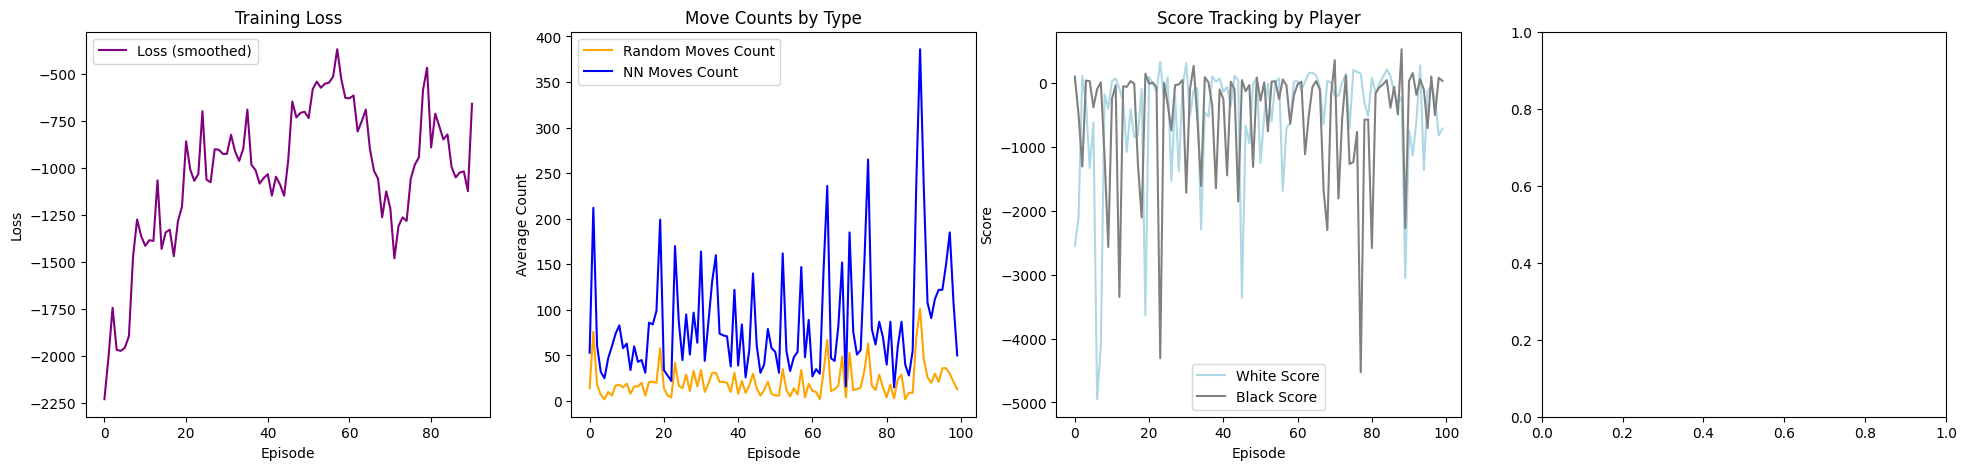

Episode 100: Loss = -682.3300, Result = Draw, Winner = Draw, Moves Count = 63, Moves = [{'color': 'Black', 'move': 'd2d3', 'type': 'NN', 'score': 0.21196722984313965}, {'color': 'White', 'move': 'e7e6', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'a2a3', 'type': 'NN', 'score': 0.03326084464788437}, {'color': 'White', 'move': 'f7f6', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'h2h4', 'type': 'NN', 'score': -0.07167933136224747}, {'color': 'White', 'move': 'd7d5', 'type': 'NN', 'score': 0.14614997804164886}, {'color': 'Black', 'move': 'e1d2', 'type': 'NN', 'score': -0.10221057385206223}, {'color': 'White', 'move': 'd8e7', 'type': 'NN', 'score': 0.02564568817615509}, {'color': 'Black', 'move': 'g2g3', 'type': 'NN', 'score': -0.0447099395096302}, {'color': 'White', 'move': 'd5d4', 'type': 'NN', 'score': 0.030140027403831482}, {'color': 'Black', 'move': 'd2e1', 'type': 'NN', 'score': -0.10651856660842896}, {'color': 'White', 'move': 'e8d7', 'type': 'random

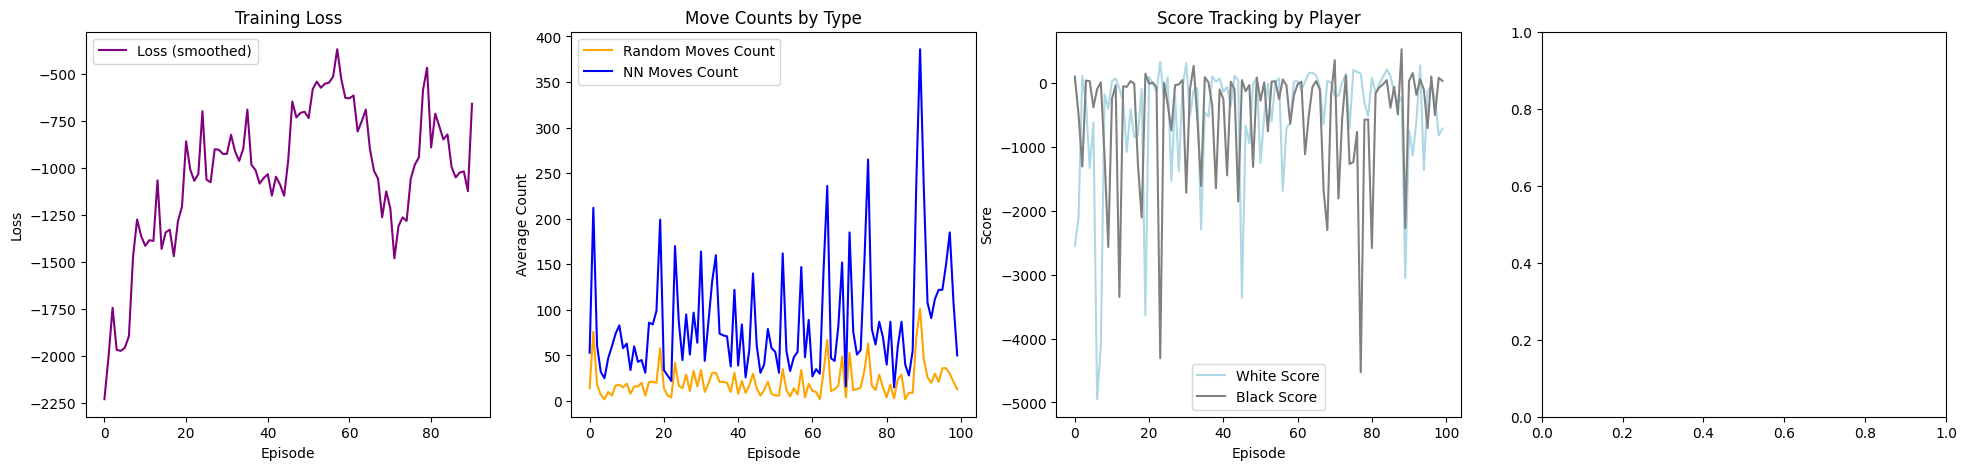

In [9]:
model = ChessNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
results = train_model(model, optimizer, episodes=100)


In [14]:
# print(results.head(5))
# print(results.tail(5))
print(results['Winner'].value_counts())
print(results['Moves'].value_counts())
# with pd.option_context('display.max_colwidth', None):
#     print(results)

Winner
Draw     97
Black     3
Name: count, dtype: int64
Moves
[{'color': 'Black', 'move': 'g1f3', 'type': 'NN', 'score': 0.0583411380648613}, {'color': 'White', 'move': 'e7e5', 'type': 'NN', 'score': 0.06756016612052917}, {'color': 'Black', 'move': 'g2g4', 'type': 'NN', 'score': 0.06157528981566429}, {'color': 'White', 'move': 'g7g6', 'type': 'NN', 'score': 0.05389108508825302}, {'color': 'Black', 'move': 'g4g5', 'type': 'NN', 'score': 0.06794507056474686}, {'color': 'White', 'move': 'f8g7', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'b2b3', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'g7f6', 'type': 'NN', 'score': 0.055059053003787994}, {'color': 'Black', 'move': 'f1h3', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'f6g5', 'type': 'NN', 'score': 0.059904541820287704}, {'color': 'Black', 'move': 'a2a3', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'g5h6', 'type': 'NN', 'score': 0.06490973383188248}, {'color': 'Black', 

In [11]:
torch.save(model.state_dict(), 'chess_model.pth')
print("Model saved successfully.")


Model saved successfully.


In [12]:
model = ChessNN()
model.load_state_dict(torch.load('chess_model.pth'))
model.eval()
print("Model loaded and set to evaluation mode.")


Model loaded and set to evaluation mode.


In [13]:
def watch_model_play(model, ignore_draws=False, ignore_fivefold_repetition=False, ignore_seventyfive_moves=False):
    board = chess.Board()
    move_count = 0
    white_moves = deque(maxlen=15)
    black_moves = deque(maxlen=15)

    while True:
        if move_count > 250:
            print("Stopping due to too many moves")
            break

        if board.is_game_over():
            if board.is_checkmate():
                print("Checkmate.")
                break
            elif not ignore_draws or not ignore_fivefold_repetition or not ignore_seventyfive_moves:
                if board.can_claim_draw():
                    print("Draw can be claimed.")
                if board.is_stalemate():
                    print("Stalemate reached.")
                if board.is_insufficient_material():
                    print("Insufficient material for a checkmate.")
                if not ignore_seventyfive_moves and board.is_seventyfive_moves():
                    print("75-move rule reached.")
                if not ignore_fivefold_repetition and board.is_fivefold_repetition():
                    print("Fivefold repetition reached.")
                if board.is_variant_draw():
                    print("Draw by variant-specific rules.")
                break

        result = select_move(model, board, epsilon=0)
        if result is None:
            print("No legal moves available")
            break
        move, score = result
        board.push(move)
        clear_output(wait=True)
        display(HTML(chess.svg.board(board=board, lastmove=move, size=400)))
        print("Move:", move.uci())
        print("White to move" if board.turn else "Black to move")

        # Store the move in the appropriate deque
        if board.turn:  # If it's White's turn, Black has just moved
            black_moves.append(move.uci())
        else:  # It's Black's turn, White has just moved
            white_moves.append(move.uci())

        time.sleep(.1)  # Increase delay for visibility
        move_count += 1

    print(f"\nGame result: {board.result()}")
    print("Move Count:", move_count)
    print("Last 15 moves by White:", list(white_moves))
    print("Last 15 moves by Black:", list(black_moves))

# Example usage (assuming your model and setup are correctly defined)
watch_model_play(model, ignore_draws=True, ignore_fivefold_repetition=True, ignore_seventyfive_moves=True)


Move: a1a2
Black to move
Stopping due to too many moves

Game result: 1/2-1/2
Move Count: 251
Last 15 moves by White: ['c1e3', 'a2a1', 'a1a2', 'f1d2', 'd2f1', 'e3c1', 'c1e3', 'a2a1', 'a1a2', 'f1d2', 'd2f1', 'e3c1', 'c1e3', 'a2a1', 'a1a2']
Last 15 moves by Black: ['e8f8', 'f8b8', 'b8e8', 'e8f8', 'f8b8', 'b8e8', 'e8f8', 'f8b8', 'b8e8', 'e8f8', 'f8b8', 'b8e8', 'e8f8', 'f8b8', 'b8e8']
